<a href="https://colab.research.google.com/github/Yin-Zhang-TR/DeepLearning_CourseWork/blob/master/AX_2019.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Run this to import the right things
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import warnings
warnings.filterwarnings("ignore")

import collections
import math
import os
import random
from six.moves import urllib
import io
import shutil

from IPython.display import clear_output, Image, display, HTML


import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as sk_metrics
import time
import scipy.io as sio
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

from keras import layers
from keras import models
from keras import optimizers
from keras import losses

from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras.optimizers import SGD
from keras.utils import np_utils
from scipy.misc import imresize

from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import preprocess_input, decode_predictions, ResNet50
from keras.preprocessing import image
from keras import regularizers
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Flatten
from keras import backend as K
from keras.utils import np_utils

In [3]:
#@title Load the SVHN data sets
SVHN_DIR = './svhn_photos'
TRAIN_FRACTION = 0.8
RANDOM_SEED = 2018


def download_images():
  """If the images aren't already downloaded, save them to FLOWERS_DIR."""
  if not os.path.exists(SVHN_DIR):    
    TRAIN_DOWNLOAD_URL = 'http://ufldl.stanford.edu/housenumbers/train_32x32.mat'
#     print('Downloading SVHN Train images from %s...' % TRAIN_DOWNLOAD_URL)
    urllib.request.urlretrieve(TRAIN_DOWNLOAD_URL, 'train_32x32.mat')
    #!tar xfz train.tgz
    
    TEST_DOWNLOAD_URL = 'http://ufldl.stanford.edu/housenumbers/test_32x32.mat'
#     print('Downloading SVHN Test images from %s...' % TEST_DOWNLOAD_URL)
    urllib.request.urlretrieve(TEST_DOWNLOAD_URL, 'test_32x32.mat')
    
    EXTRA_DOWNLOAD_URL = 'http://ufldl.stanford.edu/housenumbers/extra_32x32.mat'
#     print('Downloading SVHN Extra images from %s...' % EXTRA_DOWNLOAD_URL)
    urllib.request.urlretrieve(EXTRA_DOWNLOAD_URL, 'extra_32x32.mat')
    #!tar xfz test.tgz
  print('SVHN Dataset has been downloaded!')
  
download_images()


SVHN Dataset has been downloaded!


In [0]:
#@title Data Pre-Processing
train_file = './train_32x32.mat'
test_file  = './test_32x32.mat'
extra_file = './extra_32x32.mat'

train_data = sio.loadmat(train_file)
test_data = sio.loadmat(test_file)

batch_size = 64

traindata = train_data['X'].transpose(3,0,1,2).astype('float32')
testdata = test_data['X'].transpose(3,0,1,2).astype('float32')
trainlabel = train_data['y']
testlabel = test_data['y']

trainlabel = np_utils.to_categorical(trainlabel, 11)
testlabel = np_utils.to_categorical(testlabel, 11)

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input, rescale=1./255)

train_generator      = data_generator.flow(traindata, trainlabel, batch_size=batch_size)
validation_generator = data_generator.flow(testdata, testlabel, batch_size=batch_size)
evaluation_generator = data_generator.flow(testdata, testlabel, batch_size=batch_size)

#Problem Analysis

To create a classifier to classify a collection of images, the Street View House Numbers (SVHN) Dataset is picked. SVHN dataset is collected from Google street view and built for developing machine learning and object recognition algorithms. 

The main task for this dataset is to recognise the digitals from each image with a few preprocessing of images, which can be used in many fields, such as for auto-driving cars to recognise the speed limitation, or for detection of plate numbers with cameras.

In this dataset, there are 10 classes for each number from 0 to 9 (Digit '1' has label 1, '9' has label 9 and '0' has label 10), and 
73257 digits for training, 26032 digits for testing, and 531131 additional, somewhat less difficult samples, to use as extra training data. The formats come in two types:
1. Original images with character level bounding boxes.
2. MNIST-like 32-by-32 images centered around a single character (many of the images do contain some distractors at the sides).

The one used in this coursework is the MNIST-like one which has been labelled for each digit.

#Dataset analysis and visualisation

Before creating a classifier to deal with these images, some information of itself would be discussed, which could provide some help to reduce the difficulty to built this classifier. Because the number of images in the dataset is enough to train the classifier model, data augmentation will not be implemented in this task.

The shapes of training and test data are shown below:

In [0]:
#@title Show shape of the dataset
print('The shape of training data is number: %s, highth: %s, weigth: %s, channel: %s' % (traindata.shape[0],traindata.shape[1],traindata.shape[2],traindata.shape[3]))
print('The shape of test     data is number: %s, highth: %s, weigth: %s, channel: %s' % (testdata.shape[0],testdata.shape[1],testdata.shape[2],testdata.shape[3]))

The shape of training data is number: 73257, highth: 32, weigth: 32, channel: 3
The shape of test     data is number: 26032, highth: 32, weigth: 32, channel: 3


The digital distributions of training and test data is shown below:

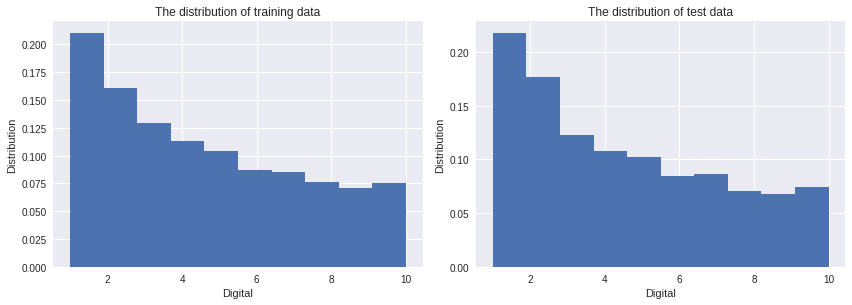

In [0]:
#@title Show digital distributions
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(2,2,1)
ax.hist(train_data['y'], bins=10, normed=True)
ax.set_title("The distribution of training data")
ax.set_xlabel("Digital")
ax.set_ylabel("Distribution")

ax = fig.add_subplot(2,2,2)
ax.hist(test_data['y'], bins=10, normed=True)
ax.set_title("The distribution of test data")
ax.set_xlabel("Digital")
ax.set_ylabel("Distribution")

# plt.xticks(fontproperties=songTi,fontsize=12)
# plt.yticks(fontproperties=songTi,fontsize=12)
plt.ylabel('Distribution')
plt.xlabel('Digital')

plt.tight_layout()
plt.show()

Due to the clip of original images to gain each digital ones, many of the images do contain some distractors at the sides, which could influent the accuracy of the model.

![alt text](http://ufldl.stanford.edu/housenumbers/32x32eg.png)


#Candidate Network Architectures

To create a network to solve this task, an elementary model as baseline one should be created first. A simple linear model as a traditional classifier will be used to measure different candidate performance. 

The second candidate is six convnetial network model which is introduced in Lab. It is a simple one to implement due to no regularisation methods.

A similar six convnetial network model with regularisation methods (Dropout and Batch Normalization) will be created to compare with the previous one. As the very similar number of parameters both trained and non-trained ones, the accuracy of these two methods should be similar, what should be focused on is the speed of convergence and time consumption.


Finally, because of the potential limitation of computational resource, a pre-trained network, ResNet50, will be used in a solution based on transfer learning to solve this task. The first step to use this pre-trained network, it should freeze all layers of ResNet50 and train the output layer to fit this dataset. Then the top layer should be unfrozen to improve the performance.

In [0]:
#@title Candidate One: Simple Two Layer Densely Connected Model
input_shape=(32, 32, 3)
batch_size = 64

model_baseline = models.Sequential()
model_baseline.add(layers.Flatten(input_shape=input_shape))
model_baseline.add(layers.Dense(512, activation='relu'))
model_baseline.add(layers.Dense(11, activation='softmax'))

model_baseline.summary()

model_baseline.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'] )


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_7 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               1573376   
_________________________________________________________________
dense_15 (Dense)             (None, 11)                5643      
Total params: 1,579,019
Trainable params: 1,579,019
Non-trainable params: 0
_________________________________________________________________


In [0]:
#@title Candidate Two: Six Convnetial Network Model
input_shape=(32, 32, 3)

model = models.Sequential()
model.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2))
# model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3, 3), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2))
# model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(128, (3, 3), padding="same"))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=2))
# model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dropout(0.3))

model.add(layers.Dense(11, activation='softmax'))
model.summary()

lr = 0.1 #learning_rate
optimizers = {"SGD": optimizers.SGD(lr=lr), "RMSprop": optimizers.RMSprop(lr=lr),
              "Adadelta": optimizers.Adadelta(lr=lr), "Adam": optimizers.Adam(lr=lr)}

model.compile(loss=losses.categorical_crossentropy,
              optimizer=optimizers['SGD'],
              metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
activation_80 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_81 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 14, 14, 64)        18496     
_________________________________________________________________
activation_82 (Activation)   (None, 14, 14, 64)        0         
__________

In [0]:
#@title Candidate Three: Six Convnetial Network Model with Regularisation
input_shape=(32, 32, 3)

model_bn = models.Sequential()
model_bn.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding="same"))
model_bn.add(layers.BatchNormalization())
model_bn.add(layers.Activation('relu'))
model_bn.add(layers.Conv2D(32, (3, 3), padding="same"))
model_bn.add(layers.BatchNormalization())
model_bn.add(layers.Activation('relu'))
model_bn.add(layers.MaxPooling2D(pool_size=2))
model_bn.add(layers.Dropout(0.3))

model_bn.add(layers.Conv2D(64, (3, 3)))
model_bn.add(layers.BatchNormalization())
model_bn.add(layers.Activation('relu'))
model_bn.add(layers.Conv2D(64, (3, 3), padding="same"))
model_bn.add(layers.BatchNormalization())
model_bn.add(layers.Activation('relu'))
model_bn.add(layers.MaxPooling2D(pool_size=2))
model_bn.add(layers.Dropout(0.3))

model_bn.add(layers.Conv2D(128, (3, 3)))
model_bn.add(layers.BatchNormalization())
model_bn.add(layers.Activation('relu'))
model_bn.add(layers.Conv2D(128, (3, 3), padding="same"))
model_bn.add(layers.BatchNormalization())
model_bn.add(layers.Activation('relu'))
model_bn.add(layers.MaxPooling2D(pool_size=2))
model_bn.add(layers.Dropout(0.3))

model_bn.add(layers.Flatten())
model_bn.add(layers.Dense(512, activation='relu'))
model_bn.add(layers.Dropout(0.3))

model_bn.add(layers.Dense(11, activation='softmax'))
model_bn.summary()

lr = 0.1 #learning_rate
# optimizers = {"SGD": optimizers.SGD(lr=lr), "RMSprop": optimizers.RMSprop(lr=lr),
#               "Adadelta": optimizers.Adadelta(lr=lr), "Adam": optimizers.Adam(lr=lr)}


model_bn.compile(loss=losses.categorical_crossentropy,
              optimizer=SGD(lr=lr),
              metrics=['accuracy'])



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_85 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_55 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_183 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_56 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
activation_184 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 16, 32)        0         
__________

In [0]:
#@title Candidate Four: Transfer Learning Mothed with ResNet50

# create the base pre-trained model
# base_model = InceptionV3(weights='imagenet', include_top=False)
base_model = ResNet50(weights='imagenet', include_top=False)
# base_model = VGG16(weights='imagenet', include_top=False)

lamb = 0.001

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# and a logistic layer -- let's say we have 200 classes
predictions = Dense(11, activation='softmax')(x)

# this is the model we will train
model_resnet50 = Model(inputs=base_model.input, outputs=predictions)

model_resnet50.summary()

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model_resnet50.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'] )


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [0]:
#@title Baseline Method Training and Performance
history_baseline = model_baseline.fit_generator(
      train_generator,
      steps_per_epoch=len(traindata)/batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(testdata)/batch_size)

evaluation_result_baseline = model_baseline.evaluate_generator(validation_generator, steps=100, verbose=1)

model_baseline.save('model_baseline.h5')

Epoch 1/10
1145/1144 [==============================] - 16s 14ms/step - loss: 1.3500 - acc: 0.5899 - val_loss: 1.2988 - val_acc: 0.6207
Epoch 2/10
1145/1144 [==============================] - 13s 12ms/step - loss: 0.8842 - acc: 0.7378 - val_loss: 0.9563 - val_acc: 0.7247
Epoch 3/10
1145/1144 [==============================] - 14s 12ms/step - loss: 0.7552 - acc: 0.7789 - val_loss: 1.0408 - val_acc: 0.7320
Epoch 4/10
1145/1144 [==============================] - 14s 12ms/step - loss: 0.6889 - acc: 0.8008 - val_loss: 0.8466 - val_acc: 0.7734
Epoch 5/10
1145/1144 [==============================] - 13s 12ms/step - loss: 0.6441 - acc: 0.8140 - val_loss: 0.9623 - val_acc: 0.7538
Epoch 6/10
1145/1144 [==============================] - 14s 12ms/step - loss: 0.6096 - acc: 0.8246 - val_loss: 0.8467 - val_acc: 0.7846
Epoch 7/10
1145/1144 [==============================] - 14s 12ms/step - loss: 0.5844 - acc: 0.8319 - val_loss: 1.2254 - val_acc: 0.7291
Epoch 8/10
1145/1144 [==========================

In [0]:
#@title Six Convnetial Network Method Training and Performance

history = model.fit_generator(
      train_generator,
      steps_per_epoch=len(traindata)/batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(testdata)/batch_size)

model.save('model_fit_generator.h5')


Epoch 1/10
1145/1144 [==============================] - 36s 31ms/step - loss: 1.4498 - acc: 0.4955 - val_loss: 0.4813 - val_acc: 0.8644
Epoch 2/10
1145/1144 [==============================] - 28s 25ms/step - loss: 0.3620 - acc: 0.8927 - val_loss: 0.3243 - val_acc: 0.9105
Epoch 3/10
1145/1144 [==============================] - 28s 25ms/step - loss: 0.2693 - acc: 0.9213 - val_loss: 0.3075 - val_acc: 0.9146
Epoch 4/10
1145/1144 [==============================] - 28s 24ms/step - loss: 0.2181 - acc: 0.9375 - val_loss: 0.2680 - val_acc: 0.9261
Epoch 5/10
1145/1144 [==============================] - 28s 25ms/step - loss: 0.1811 - acc: 0.9486 - val_loss: 0.2940 - val_acc: 0.9229
Epoch 6/10
1145/1144 [==============================] - 28s 24ms/step - loss: 0.1504 - acc: 0.9559 - val_loss: 0.3235 - val_acc: 0.9211
Epoch 7/10
1145/1144 [==============================] - 29s 25ms/step - loss: 0.1270 - acc: 0.9627 - val_loss: 0.3188 - val_acc: 0.9191
Epoch 8/10
1145/1144 [==========================

In [0]:
#@title Six Convnetial Network with Batch Normalization Method Training and Performance

history_bn = model_bn.fit_generator(
      train_generator,
      steps_per_epoch=len(traindata)/batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(testdata)/batch_size)

model_bn.save('model_bn_fit_generator.h5')


Epoch 1/10
1145/1144 [==============================] - 53s 47ms/step - loss: 1.0778 - acc: 0.6376 - val_loss: 0.3851 - val_acc: 0.8842
Epoch 2/10
1145/1144 [==============================] - 41s 36ms/step - loss: 0.4138 - acc: 0.8731 - val_loss: 0.2937 - val_acc: 0.9128
Epoch 3/10
1145/1144 [==============================] - 41s 36ms/step - loss: 0.3373 - acc: 0.8986 - val_loss: 0.2649 - val_acc: 0.9233
Epoch 4/10
1145/1144 [==============================] - 41s 36ms/step - loss: 0.2955 - acc: 0.9120 - val_loss: 0.2283 - val_acc: 0.9332
Epoch 5/10
1145/1144 [==============================] - 41s 36ms/step - loss: 0.2750 - acc: 0.9186 - val_loss: 0.2031 - val_acc: 0.9441
Epoch 6/10
1145/1144 [==============================] - 41s 36ms/step - loss: 0.2528 - acc: 0.9258 - val_loss: 0.2020 - val_acc: 0.9446
Epoch 7/10
1145/1144 [==============================] - 42s 36ms/step - loss: 0.2394 - acc: 0.9301 - val_loss: 0.2044 - val_acc: 0.9432
Epoch 8/10
1145/1144 [==========================

In [0]:
#@title ResNet50 Transfer Learning Method Training and Performance
# train the model on the new data for a few epochs
history_resnet50 = model_resnet50.fit_generator(train_generator,
      steps_per_epoch=len(traindata)/batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(testdata)/batch_size)


# # we chose to train the top 2 inception blocks, i.e. we will freeze
# # the first 249 layers and unfreeze the rest:
for layer in model_resnet50.layers[:249]:
   layer.trainable = False
for layer in model_resnet50.layers[249:]:
   layer.trainable = True

# # we need to recompile the model for these modifications to take effect
# # we use SGD with a low learning rate
from keras.optimizers import SGD
model_resnet50.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy', metrics=['accuracy'])

# # we train our model again (this time fine-tuning the top 2 inception blocks
# # alongside the top Dense layers
# model.fit_generator(FILL IN YOUR DETAILS...)
history_resnet50_finetune = model_resnet50.fit_generator(train_generator,
      steps_per_epoch=len(traindata)/batch_size,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=len(testdata)/batch_size)

# valuation_result_resnet50 = model_resnet50.evaluate_generator(validation_generator, steps=100, verbose=1)

model_resnet50.save('model_resnet50_fit_generator.h5')

Epoch 1/10
1145/1144 [==============================] - 66s 58ms/step - loss: 2.2194 - acc: 0.3103 - val_loss: 3.7204 - val_acc: 0.1978
Epoch 2/10
1145/1144 [==============================] - 59s 52ms/step - loss: 1.9906 - acc: 0.3607 - val_loss: 3.6934 - val_acc: 0.1966
Epoch 3/10
1145/1144 [==============================] - 59s 52ms/step - loss: 1.9700 - acc: 0.3664 - val_loss: 4.8215 - val_acc: 0.1951
Epoch 4/10
1145/1144 [==============================] - 60s 52ms/step - loss: 1.9697 - acc: 0.3655 - val_loss: 4.1580 - val_acc: 0.1953
Epoch 5/10
1145/1144 [==============================] - 60s 52ms/step - loss: 1.9691 - acc: 0.3671 - val_loss: 4.0507 - val_acc: 0.1960
Epoch 6/10
1145/1144 [==============================] - 59s 51ms/step - loss: 1.9665 - acc: 0.3672 - val_loss: 3.8247 - val_acc: 0.1956
Epoch 7/10
1145/1144 [==============================] - 59s 51ms/step - loss: 1.9702 - acc: 0.3680 - val_loss: 4.6300 - val_acc: 0.1955
Epoch 8/10
1145/1144 [==========================

#Evaluation of Performance

After training all four medel, it should compare them with performance, accuracy and loss of train data and test data are the main measures to compare and analysis. 

From the table and charts, Six ConV with BN has the best performance on both accuracy and loss, either in Train data or Validation data. With the help of Batch Normalization, this model has the fastest converence rate. 

In [0]:
#@title Comparison of Accuracy and Loss
# evaluate the model on the test data
model_baseline_loss, model_baseline_acc = model_baseline.evaluate(testdata/255., testlabel, verbose=False)
model_loss, model_acc = model.evaluate(testdata/255., testlabel, verbose=False)
model_bn_loss, model_bn_acc = model_bn.evaluate(testdata/255., testlabel, verbose=False)
model_resnet50_loss, model_resnet50_acc = model_resnet50.evaluate(testdata/255., testlabel, verbose=False)
# print(test_acc, test_loss)

from prettytable import PrettyTable

x = PrettyTable(["Model Name", "Train Accuracy", "Train Loss", "Validation Accuracy", "Validation Loss"])  
x.align["Model Name"] = "l"
x.align["Train Accuracy"] = "l"
x.align["Train Loss"] = "l"
x.align["Validation Accuracy"] = "l"
x.align["Validation Loss"] = "l"
x.padding_width = 1
x.add_row(["Base Line(Simple Dense Layers)",history_baseline.history['acc'][-1], history_baseline.history['loss'][-1], history_baseline.history['val_acc'][-1], history_baseline.history['val_loss'][-1]])  
x.add_row(["Six ConV",history.history['acc'][-1], history.history['loss'][-1], history.history['val_acc'][-1], history.history['val_loss'][-1]])  
x.add_row(["Six ConV with BN",history_bn.history['acc'][-1], history_bn.history['loss'][-1], history_bn.history['val_acc'][-1], history_bn.history['val_loss'][-1]])  
x.add_row(["ResNet50",history_resnet50.history['acc'][-1], history_resnet50.history['loss'][-1], history_resnet50.history['val_acc'][-1], history_resnet50.history['val_loss'][-1]])  

print(x)


+--------------------------------+---------------------+---------------------+---------------------+---------------------+
| Model Name                     | Train Accuracy      | Train Loss          | Validation Accuracy | Validation Loss     |
+--------------------------------+---------------------+---------------------+---------------------+---------------------+
| Base Line(Simple Dense Layers) | 0.8513316133725715  | 0.524536843718531   | 0.7996312230733837  | 0.8202460747814354  |
| Six ConV                       | 0.9762343530311096  | 0.07974436925698086 | 0.9246696373693916  | 0.3789503853344522  |
| Six ConV with BN               | 0.9405927078697903  | 0.20373543850251816 | 0.950944990743943   | 0.17866429701887104 |
| ResNet50                       | 0.37171874359681906 | 1.9644101442744533  | 0.19714197911180156 | 4.29020723420268    |
+--------------------------------+---------------------+---------------------+---------------------+---------------------+


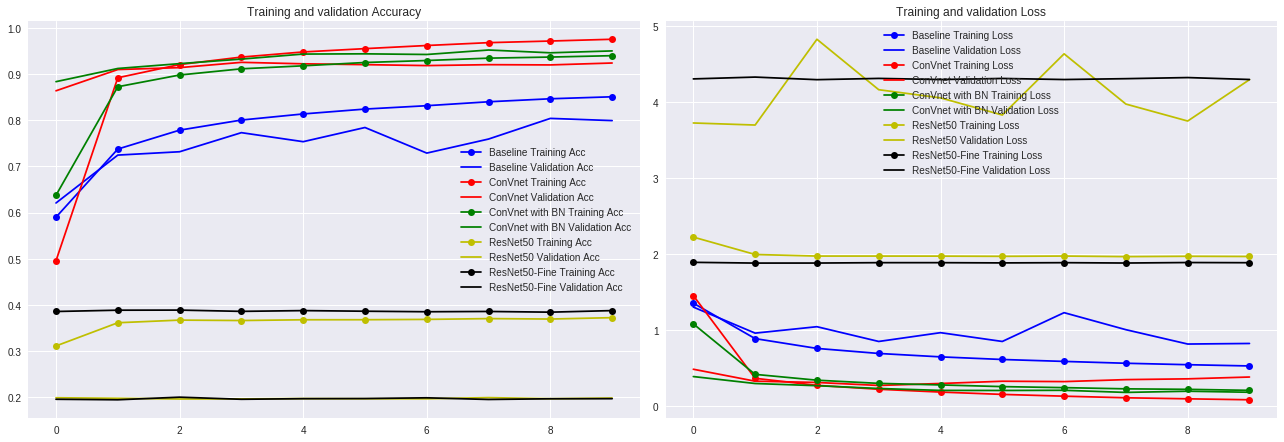

In [0]:
#@title Comparison of Accuracy and Loss
acc_baseline = history_baseline.history['acc']
val_acc_baseline = history_baseline.history['val_acc']
loss_baseline = history_baseline.history['loss']
val_loss_baseline = history_baseline.history['val_loss']

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

acc_bn = history_bn.history['acc']
val_acc_bn = history_bn.history['val_acc']
loss_bn = history_bn.history['loss']
val_loss_bn = history_bn.history['val_loss']

acc_resnet50 = history_resnet50.history['acc']
val_acc_resnet50 = history_resnet50.history['val_acc']
loss_resnet50 = history_resnet50.history['loss']
val_loss_resnet50 = history_resnet50.history['val_loss']

acc_resnet50_fine = history_resnet50_finetune.history['acc']
val_acc_resnet50_fine = history_resnet50_finetune.history['val_acc']
loss_resnet50_fine = history_resnet50_finetune.history['loss']
val_loss_resnet50_fine = history_resnet50_finetune.history['val_loss']




epochs = range(len(acc))



fig = plt.figure(figsize=(18,12))

ax = fig.add_subplot(2,2,1)
ax.plot(epochs, acc_baseline, 'bo-', label='Baseline Training Acc')
ax.plot(epochs, val_acc_baseline, 'b', label='Baseline Validation Acc')
ax.plot(epochs, acc, 'ro-', label='ConVnet Training Acc')
ax.plot(epochs, val_acc, 'r', label='ConVnet Validation Acc')
ax.plot(epochs, acc_bn, 'go-', label='ConVnet with BN Training Acc')
ax.plot(epochs, val_acc_bn, 'g', label='ConVnet with BN Validation Acc')
ax.plot(epochs, acc_resnet50, 'yo-', label='ResNet50 Training Acc')
ax.plot(epochs, val_acc_resnet50, 'y', label='ResNet50 Validation Acc')
ax.plot(epochs, acc_resnet50_fine, 'ko-', label='ResNet50-Fine Training Acc')
ax.plot(epochs, val_acc_resnet50_fine, 'k', label='ResNet50-Fine Validation Acc')
ax.set_title('Training and validation Accuracy')
plt.legend()

ax = fig.add_subplot(2,2,2)
ax.plot(epochs, loss_baseline, 'bo-', label='Baseline Training Loss')
ax.plot(epochs, val_loss_baseline, 'b', label='Baseline Validation Loss')
ax.plot(epochs, loss, 'ro-', label='ConVnet Training Loss')
ax.plot(epochs, val_loss, 'r', label='ConVnet Validation Loss')
ax.plot(epochs, loss_bn, 'go-', label='ConVnet with BN Training Loss')
ax.plot(epochs, val_loss_bn, 'g', label='ConVnet with BN Validation Loss')
ax.plot(epochs, loss_resnet50, 'yo-', label='ResNet50 Training Loss')
ax.plot(epochs, val_loss_resnet50, 'y', label='ResNet50 Validation Loss')
ax.plot(epochs, loss_resnet50_fine, 'ko-', label='ResNet50-Fine Training Loss')
ax.plot(epochs, val_loss_resnet50_fine, 'k', label='ResNet50-Fine Validation Loss')
ax.set_title('Training and validation Loss')

plt.legend()
plt.tight_layout()
plt.show()


In [0]:
#############################################################################
# Compute AUC and ROC
# from sklearn.metrics import roc_curve, roc_auc_score 

# fpr_bn, tpr_bn, th_bn = roc_curve(testlabel, model_bn.predict_generator(validation_generator, steps=100, verbose=1))

# plt.plot(fpr_bn, tpr_bn, "r", label='model_bn')
# plt.xlabel("1-Specificity  or False Positive Rate")
# plt.ylabel("Sensitivity or True Positive Rate")
# plt.legend()
# plt.show()

# auc_knn = roc_auc_score(testlabel, model_bn.predict_generator(validation_generator, steps=100, verbose=1))
# print("ConVNet with BN AUC:%.10f"%auc_knn)


# model_bn.predict_generator(validation_generator, steps=100, verbose=1).shape
# model_bn.predict(testdata)

# print('Predicted:', decode_predictions(model_bn.predict(testdata), top=3)[0])

#Hyperparameters Search

Using sklearn API, some hyperparameters can be tested automatically. By testing different values of each hyperparameter, the performance will be reported by this sklearn tool, and the best values of hyperparameters tested will be choisen as the final network for use.

In [10]:
#@title Hyperparameters Search -- Epochs and Batch_size
# Use scikit-learn to grid search the batch size and epochs
import warnings
warnings.filterwarnings('ignore')

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import layers
from keras import models
from keras import optimizers
from keras import losses


lr = 0.1 #learning_rate
optimizers = {"SGD": optimizers.SGD(lr=lr), "RMSprop": optimizers.RMSprop(lr=lr),
              "Adadelta": optimizers.Adadelta(lr=lr), "Adam": optimizers.Adam(lr=lr)}

# Function to create model, required for KerasClassifier
def create_model():
  input_shape=(32, 32, 3)

  model_bn = models.Sequential()
  model_bn.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(32, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(64, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(64, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(128, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(128, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Flatten())
  model_bn.add(layers.Dense(512, activation='relu'))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Dense(11, activation='softmax'))
#   model_bn.summary()

  model_bn.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers['SGD'],
                metrics=['accuracy'])

  return model_bn



# fix random seed for reproducibility
seed = 2018
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, verbose=0)

# define the grid search parameters
batch_size = [32, 64, 128, 512]
epochs = [10,20,30]
param_grid = dict(batch_size=batch_size, epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=2)
grid_result = grid.fit(traindata, trainlabel)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 3 folds for each of 12 candidates, totalling 36 fits
[CV] batch_size=32, epochs=10 ........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ......................... batch_size=32, epochs=10, total= 5.0min
[CV] batch_size=32, epochs=10 ........................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  5.2min remaining:    0.0s


[CV] ......................... batch_size=32, epochs=10, total= 4.7min
[CV] batch_size=32, epochs=10 ........................................
[CV] ......................... batch_size=32, epochs=10, total= 4.9min
[CV] batch_size=32, epochs=20 ........................................
[CV] ......................... batch_size=32, epochs=20, total= 9.9min
[CV] batch_size=32, epochs=20 ........................................
[CV] ......................... batch_size=32, epochs=20, total= 9.6min
[CV] batch_size=32, epochs=20 ........................................
[CV] ......................... batch_size=32, epochs=20, total=10.4min
[CV] batch_size=32, epochs=30 ........................................
[CV] ......................... batch_size=32, epochs=30, total=15.4min
[CV] batch_size=32, epochs=30 ........................................
[CV] ......................... batch_size=32, epochs=30, total=15.4min
[CV] batch_size=32, epochs=30 ........................................
[CV] .

[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 248.2min finished


Best: 0.942913 using {'batch_size': 32, 'epochs': 20}
0.934313 (0.004171) with: {'batch_size': 32, 'epochs': 10}
0.942913 (0.001524) with: {'batch_size': 32, 'epochs': 20}
0.941753 (0.002801) with: {'batch_size': 32, 'epochs': 30}
0.874374 (0.086596) with: {'batch_size': 64, 'epochs': 10}
0.898522 (0.023974) with: {'batch_size': 64, 'epochs': 20}
0.921591 (0.031198) with: {'batch_size': 64, 'epochs': 30}
0.920513 (0.006627) with: {'batch_size': 128, 'epochs': 10}
0.938054 (0.001011) with: {'batch_size': 128, 'epochs': 20}
0.936102 (0.002412) with: {'batch_size': 128, 'epochs': 30}
0.853570 (0.017909) with: {'batch_size': 512, 'epochs': 10}
0.908077 (0.014173) with: {'batch_size': 512, 'epochs': 20}
0.928771 (0.003230) with: {'batch_size': 512, 'epochs': 30}


In [0]:
#@title Hyperparameters Search -- Optimizers
# Use scikit-learn to grid search the batch size and epochs
import warnings
warnings.filterwarnings('ignore')

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import layers
from keras import models
from keras import optimizers
from keras import losses


lr = 0.1 #learning_rate
optimizers = {"SGD": optimizers.SGD(lr=lr), "RMSprop": optimizers.RMSprop(lr=lr),
              "Adadelta": optimizers.Adadelta(lr=lr), "Adam": optimizers.Adam(lr=lr)}


# Function to create model, required for KerasClassifier
def create_model(optimizer='adam'):
  input_shape=(32, 32, 3)

  model_bn = models.Sequential()
  model_bn.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(32, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(64, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(64, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(128, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(128, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Flatten())
  model_bn.add(layers.Dense(512, activation='relu'))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Dense(11, activation='softmax'))
#   model_bn.summary()

  model_bn.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers['SGD'],
                metrics=['accuracy'])

  return model_bn


# fix random seed for reproducibility
seed = 2018
numpy.random.seed(seed)

# create model
model = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0)

# define the grid search parameters
optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
param_grid = dict(optimizer=optimizer)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=2)
grid_result = grid.fit(traindata, trainlabel)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
    

Fitting 3 folds for each of 7 candidates, totalling 21 fits
[CV] optimizer=SGD ...................................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................................... optimizer=SGD, total= 8.1min
[CV] optimizer=SGD ...................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  8.2min remaining:    0.0s


In [0]:
#@title Hyperparameters Search -- Learning Rate and Momentum
# Use scikit-learn to grid search the batch size and epochs
import warnings
warnings.filterwarnings('ignore')

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import layers
from keras import models
from keras import optimizers
from keras import losses


lr = 0.1 #learning_rate
optimizers = {"SGD": optimizers.SGD(lr=lr), "RMSprop": optimizers.RMSprop(lr=lr),
              "Adadelta": optimizers.Adadelta(lr=lr), "Adam": optimizers.Adam(lr=lr)}


# Function to create model, required for KerasClassifier
def create_model(learn_rate=0.01, momentum=0):
  input_shape=(32, 32, 3)

  model_bn = models.Sequential()
  model_bn.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(32, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(64, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(64, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(128, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(128, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Flatten())
  model_bn.add(layers.Dense(512, activation='relu'))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Dense(11, activation='softmax'))
#   model_bn.summary()

  model_bn.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers['SGD'],
                metrics=['accuracy'])

  return model_bn


# fix random seed for reproducibility
seed = 2018
numpy.random.seed(seed)


# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)

# define the grid search parameters
learn_rate = [0.001, 0.01, 0.1, 0.2, 0.3]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
param_grid = dict(learn_rate=learn_rate, momentum=momentum)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=1)
grid_result = grid.fit(traindata, trainlabel)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
#@title Hyperparameters Search -- Activation Method
# Use scikit-learn to grid search the batch size and epochs
import warnings
warnings.filterwarnings('ignore')

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import layers
from keras import models
from keras import optimizers
from keras import losses


lr = 0.1 #learning_rate
optimizers = {"SGD": optimizers.SGD(lr=lr), "RMSprop": optimizers.RMSprop(lr=lr),
              "Adadelta": optimizers.Adadelta(lr=lr), "Adam": optimizers.Adam(lr=lr)}


# Function to create model, required for KerasClassifier
def create_model(activation='relu'):
  input_shape=(32, 32, 3)

  model_bn = models.Sequential()
  model_bn.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(32, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(64, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(64, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(128, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(128, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Flatten())
  model_bn.add(layers.Dense(512, activation='relu'))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Dense(11, activation='softmax'))
#   model_bn.summary()

  model_bn.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers['SGD'],
                metrics=['accuracy'])

  return model_bn


# fix random seed for reproducibility
seed = 2018
numpy.random.seed(seed)


# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)

# define the grid search parameters
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
param_grid = dict(activation=activation)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=1)
grid_result = grid.fit(traindata, trainlabel)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [0]:
#@title Hyperparameters Search -- Dropout Regularization
# Use scikit-learn to grid search the batch size and epochs
import warnings
warnings.filterwarnings('ignore')

import numpy
from sklearn.model_selection import GridSearchCV
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras import layers
from keras import models
from keras import optimizers
from keras import losses


lr = 0.1 #learning_rate
optimizers = {"SGD": optimizers.SGD(lr=lr), "RMSprop": optimizers.RMSprop(lr=lr),
              "Adadelta": optimizers.Adadelta(lr=lr), "Adam": optimizers.Adam(lr=lr)}


# Function to create model, required for KerasClassifier
def create_model(dropout_rate=0.0, weight_constraint=0):
  input_shape=(32, 32, 3)

  model_bn = models.Sequential()
  model_bn.add(layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(32, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(64, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(64, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Conv2D(128, (3, 3)))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.Conv2D(128, (3, 3), padding="same"))
  model_bn.add(layers.BatchNormalization())
  model_bn.add(layers.Activation('relu'))
  model_bn.add(layers.MaxPooling2D(pool_size=2))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Flatten())
  model_bn.add(layers.Dense(512, activation='relu'))
  model_bn.add(layers.Dropout(0.3))

  model_bn.add(layers.Dense(11, activation='softmax'))
#   model_bn.summary()

  model_bn.compile(loss=losses.categorical_crossentropy,
                optimizer=optimizers['SGD'],
                metrics=['accuracy'])

  return model_bn


# fix random seed for reproducibility
seed = 2018
numpy.random.seed(seed)


# create model
model = KerasClassifier(build_fn=create_model, epochs=10, batch_size=64, verbose=0)

# define the grid search parameters
weight_constraint = [1, 2, 3, 4, 5]
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
param_grid = dict(dropout_rate=dropout_rate, weight_constraint=weight_constraint)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=1, verbose=1)
grid_result = grid.fit(traindata, trainlabel)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#Final Report

By comparing different models and tuning the hyperparameters, the accuracy of the Six ConV Network with Batch Normalization model is the highest with the lowest loss under the same condition. It can archieve 95% and has a performance of generalization. 

This model could be used to recongnize many tasks with are similar to SVHN, such as recongnizing the writen numbers, and even characters, recongnizing plate number automatically on road to improve the efficiency and effectiveness 